In [1]:
from ms_data_funcs import *
from transformer_funcs import *

import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")
    print("PyTorch version:", torch.__version__)
    print("CUDA version:", torch.version.cuda)
    print("Number of available GPUs:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

CUDA is available.
PyTorch version: 2.0.1+cu118
CUDA version: 11.8
Number of available GPUs: 1
GPU name: NVIDIA GeForce RTX 3080


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv('data/MoNA/in-silico-SMILES.csv') 
print(f"Train shape: {df.shape}")

/tmp/ipykernel_11082/4094128230.py:1: DtypeWarning: Columns (7,8,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/MoNA/in-silico-SMILES.csv')


Train shape: (1837926, 18)


In [5]:
df_test = pd.read_csv('data/MoNA/experimental-SMILES.csv')
print(f"Test shape: {df_test.shape}")

Test shape: (213326, 17)


/tmp/ipykernel_11082/3036516358.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('data/MoNA/experimental-SMILES.csv')


In [6]:
# Minimal test
n = 1000
df = df.sample(n)
df_test = df.sample(n)

In [7]:
method='direct'

In [8]:
'''label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['molecular_formula'])'''
max_mz = calculate_max_mz(df)

In [9]:
df['molecular_formula'].unique().shape

(852,)

In [10]:
smiles_vocabs = get_or_create_smiles_vocabs(df)

Loading existing character vocabulary...
SMILES vocabulary size (character): 32
Loading existing atom_wise vocabulary...
SMILES vocabulary size (atom_wise): 12
Loading existing substructure vocabulary...
SMILES vocabulary size (substructure): 38759


In [11]:
results = {}
print(f"\nSpectra tokenized with {method} tokenization:")
print(f"\nSMILES tokenized with {'character'} tokenization")
smiles_vocab = smiles_vocabs['character']

train_loader, test_loader = load_tokenized_data_with_smiles(df, df_test, 
                                                            method, 
                                                            smiles_vocab, 
                                                            max_mz=max_mz)

#num_classes = len(label_encoder.classes_)
smiles_vocab_size = len(smiles_vocab)

# sample batch used for input dimensions
sample_batch, target_batch = next(iter(train_loader))
print("Spectra shape:", sample_batch.shape)
print("SMILES shape:", target_batch.shape)
embed_depth = sample_batch.shape[3]


Spectra tokenized with direct tokenization:

SMILES tokenized with character tokenization
Spectra shape: torch.Size([32, 1, 111, 16])
SMILES shape: torch.Size([32, 150])


In [12]:
model = MS_VIT_Seq2Seq(
    smiles_vocab_size=len(smiles_vocab),
    embed_depth=embed_depth,
    d_model=64,           # Reduced from 256
    nhead=4,              # Reduced from 8
    num_layers=2,         # Reduced from 6
    dim_feedforward=256,  # Reduced from 2048
    dropout=0.1,
    num_classes=None
)

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion_seq = nn.CrossEntropyLoss(ignore_index=smiles_vocab['<pad>'])

model, history = train_model_seq2seq(model, train_loader, test_loader, 
                                     optimizer, criterion_seq, 
                                     num_epochs=5, evaluate=True, verbose=1,
                                     checkpoint_path="./model_checkpoints/",
                                     meta_tag=(method+"_character"))

Saving checkpoints to ./model_checkpoints/checkpoint_20


Epoch 1/5 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

In [14]:
results = evaluate_model_seq2seq(model, test_loader, smiles_vocab, test=True)

Sequence Accuracy: 0.4229
Average Sequence Loss: 1.2851
Valid SMILES Percentage: 0.00%
Average Tanimoto Similarity: 0.0000
Average Edit Distance: 83.08
True SMILES: O=C(NC(COC1OC(CO)C(OC2OC(CO)C(O)C(O)C2O)C(O)C1O)C(O)C=CCCCCCCCCCCCCCCCCCCCCCCCCCCCC)CCCCCCCCCCCCCCCCCC
Pred SMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

True SMILES: O=C(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(=O)NC(CO)C(O)CCCCCCCCCCCCCCCCCCCC)CCCCCCCCCCCCCCCCCC
Pred SMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

True SMILES: O=C(O)C1(OC2C(O)C(OC(CO)C2O)OC3C(O)C(O)C(OCC(NC(=O)CCCCCCCCCCCCCCCCCCCCC)C(O)C=CCCCCCCCCCCCCC)OC3CO)OC(C(O)C(O)CO)C(NC(=O)C)C(O)C1
Pred SMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

True SMILES: O=C(NC(COP(=O)([O-])OCC[N+](C)(C)C)

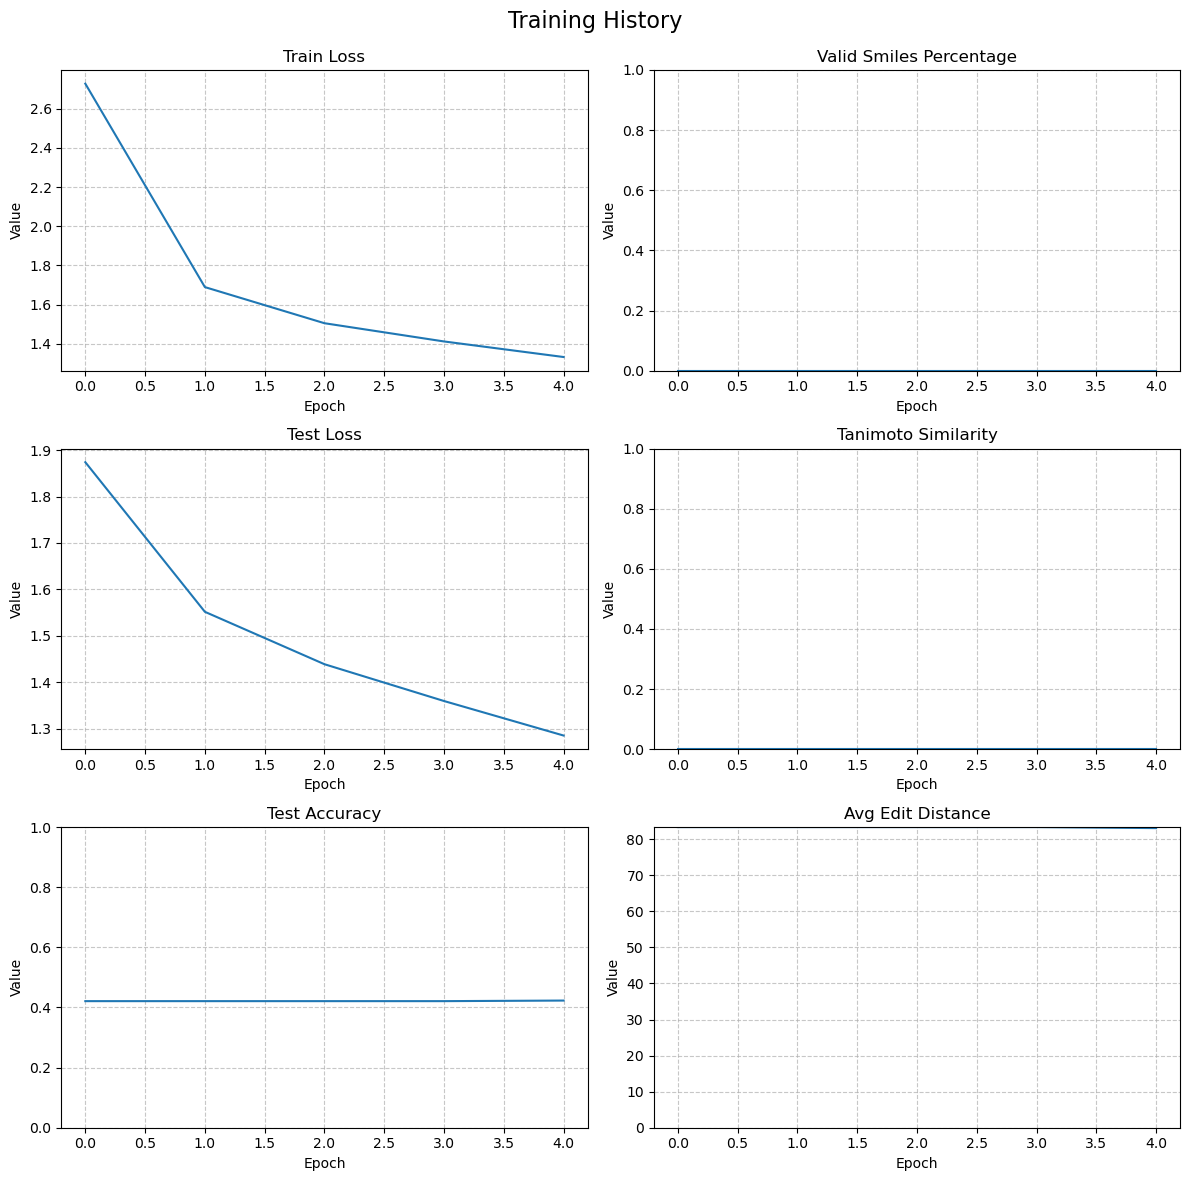

In [15]:
plot_training_history(history)